## Capstone Project - Telco customer churn dataset

## Importing Required Libraries

We begin by importing all the necessary libraries for data manipulation, model building, and evaluation.

- `pandas`, `numpy` – Data handling
- `sklearn` – Preprocessing, ML models, and metrics
- `xgboost` – Gradient boosting model

In [35]:
# Checking XGBoost version
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Model selection & preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

XGBoost version: 3.0.2


## Load and Explore the Dataset

In this section, we will:

- Load the dataset from a CSV file
- View the first few records
- Check the data types of each column
- Identify missing values in the dataset

In [36]:
# Load the dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Display the first 5 rows
print(df.head())

# Show data types and non-null counts
df.info()

# Check for missing values
df.isnull().sum()

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Data Preprocessing

In this step, we prepare the dataset for machine learning:

- Drop irrelevant columns
- Handle missing values
- Encode categorical variables
- Split features and labels
- Scale numerical features

In [37]:
# Drop irrelevant columns
df = df.drop(['customerID'], axis=1)

# Convert TotalCharges to numeric and handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])

In [38]:
# Encode the target variable (Churn: Yes/No → 1/0)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# One-hot encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [39]:
# Split features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [40]:
# Feature scaling (standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Training and Evaluation

We define a reusable function `evaluate_model()` that:

- Trains any given machine learning model
- Predicts outcomes on the test set
- Computes evaluation metrics:
  - Accuracy
  - Precision
  - Recall
  - F1 Score
  - ROC AUC Score

This will allow us to easily compare different models with the same function.

In [41]:
# Define a function to train and evaluate models
def evaluate_model(model):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Get probabilities for ROC AUC (if available!)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1, "ROC AUC": auc}

# Dictionary to store evaluation results
results = {}

## Model Training

We now train and evaluate multiple classification algorithms using the `evaluate_model()` function:

- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- Support Vector Machine (SVM)
- Naive Bayes
- K-Nearest Neighbors (KNN)

Each model’s performance will be stored in the `results` dictionary for comparison.

In [42]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
results['Logistic Regression'] = evaluate_model(log_reg)

# Decision Tree
tree = DecisionTreeClassifier(random_state=42)
results['Decision Tree'] = evaluate_model(tree)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
results['Random Forest'] = evaluate_model(rf)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
results['XGBoost'] = evaluate_model(xgb)

# SVM
svm = SVC(probability=True, random_state=42)
results['SVM'] = evaluate_model(svm)

# Naive Bayes
nb = GaussianNB()
results['Naive Bayes'] = evaluate_model(nb)

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
results['KNN'] = evaluate_model(knn)

## Model Comparison Results

We convert the `results` dictionary into a DataFrame to compare all models side by side.  
The models are sorted by Accuracy, and a bar chart is also plotted for visual clarity.

In [43]:
# Convert results dictionary to DataFrame
results_df = pd.DataFrame(results).T  # .T transposes it so models are rows

# Sort by Accuracy (or any metric you prefer)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

# Display neatly
results_df.style.background_gradient(cmap='Blues').set_caption("Model Evaluation Metrics")

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.787491,0.620579,0.516043,0.563504,0.831924
Random Forest,0.784648,0.625442,0.473262,0.538813,0.815336
SVM,0.781095,0.616197,0.467914,0.531915,0.782421
XGBoost,0.773987,0.588608,0.497326,0.539130,0.810815
KNN,0.751955,0.535211,0.508021,0.521262,0.765220
Decision Tree,0.725657,0.485222,0.526738,0.505128,0.663843
Naive Bayes,0.657427,0.428760,0.868984,0.574205,0.810223


## Grouped Bar Chart

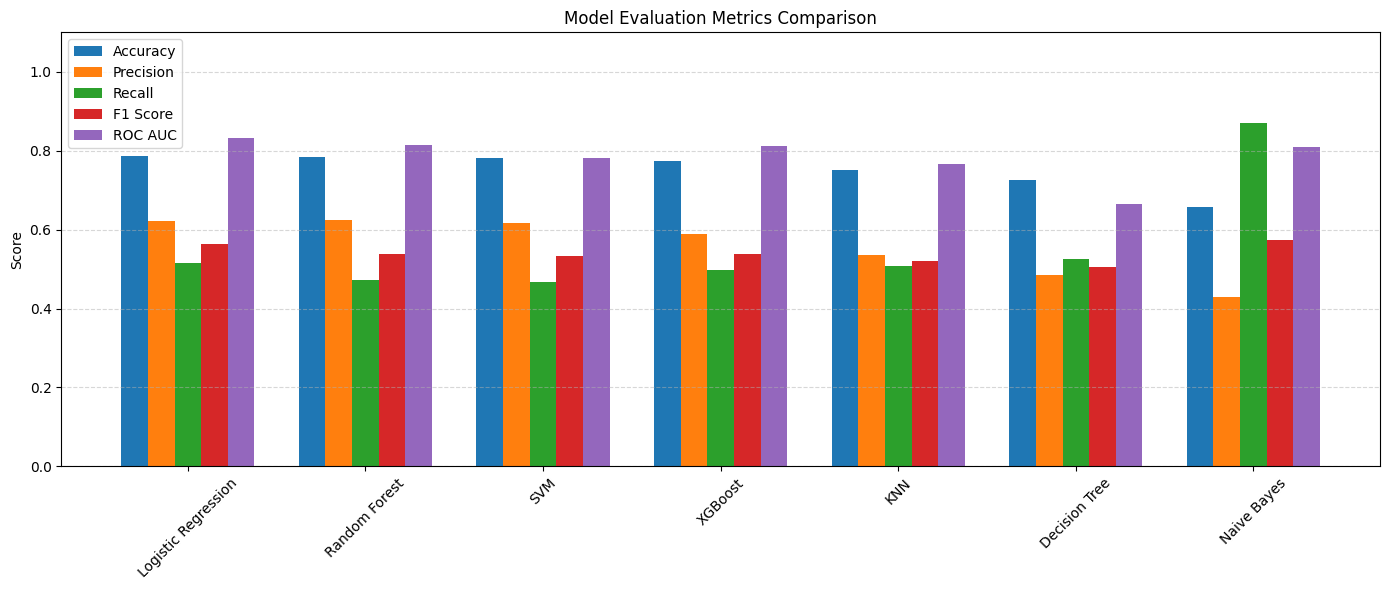

In [45]:
# Extract metric names and model names
metrics = results_df.columns.tolist()
models = results_df.index.tolist()

# Set bar positions
x = np.arange(len(models))  # One position per model
width = 0.15  # Width of each bar
num_metrics = len(metrics)

# Create plot
plt.figure(figsize=(14, 6))

# Plot one bar per metric, shifting each slightly
for i, metric in enumerate(metrics):
    plt.bar(x + i*width, results_df[metric], width=width, label=metric)

# Format the x-axis to center the group of bars under each model name
plt.xticks(x + width*(num_metrics-1)/2, models, rotation=45)

# Add labels and legend
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.title("Model Evaluation Metrics Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

To improve model performance, we apply `RandomizedSearchCV` to search for the best hyperparameters using cross-validation.

- **Scoring Metric**: ROC AUC
- **Cross-Validation**: 5-fold
- **Models Tuned**:
  - Logistic Regression
  - Random Forest
  - XGBoost

We store the best parameters found for each model in the `best_params` dictionary.

In [46]:
from sklearn.model_selection import RandomizedSearchCV

# Dictionary to store best parameters
best_params = {}

# 1. Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
grid_log_reg = RandomizedSearchCV(log_reg, param_grid_log_reg, cv=5, scoring='roc_auc', n_iter=10, random_state=42)
grid_log_reg.fit(X_train, y_train)
best_params['Logistic Regression'] = grid_log_reg.best_params_

# 2. Random Forest
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
grid_rf = RandomizedSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_iter=10, random_state=42)
grid_rf.fit(X_train, y_train)
best_params['Random Forest'] = grid_rf.best_params_

# 3. XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
grid_xgb = RandomizedSearchCV(xgb, param_grid_xgb, cv=5, scoring='roc_auc', n_iter=10, random_state=42)
grid_xgb.fit(X_train, y_train)
best_params['XGBoost'] = grid_xgb.best_params_

In [47]:
# Display the best hyperparameters
print("Best Parameters for each model:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")

Best Parameters for each model:
Logistic Regression: {'solver': 'liblinear', 'penalty': 'l1', 'C': 100}
Random Forest: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 30}
XGBoost: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


## Retraining with Best Hyperparameters

Now that we’ve tuned our models using RandomizedSearchCV, we retrain the best ones (Logistic Regression, Random Forest, and XGBoost) using their optimal parameters.

We evaluate them again using the same metrics to compare performance before and after tuning.


In [48]:
# Train models with best parameters and evaluate
tuned_results = {}

# Logistic Regression
log_reg_tuned = LogisticRegression(**best_params['Logistic Regression'], random_state=42)
tuned_results['Logistic Regression'] = evaluate_model(log_reg_tuned)

# Random Forest
rf_tuned = RandomForestClassifier(**best_params['Random Forest'], random_state=42)
tuned_results['Random Forest'] = evaluate_model(rf_tuned)

# XGBoost
xgb_tuned = XGBClassifier(**best_params['XGBoost'], eval_metric='logloss', random_state=42)
tuned_results['XGBoost'] = evaluate_model(xgb_tuned)

# Convert to DataFrame
tuned_results_df = pd.DataFrame(tuned_results).T

# Display with styling
tuned_results_df = tuned_results_df.sort_values(by='Accuracy', ascending=False)
tuned_results_df.style.background_gradient(cmap='Greens').set_caption("Tuned Model Evaluation Results")

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Random Forest,0.802416,0.679104,0.486631,0.566978,0.831597
XGBoost,0.795309,0.688596,0.419786,0.521595,0.833176
Logistic Regression,0.788913,0.624595,0.516043,0.565154,0.831701
